### Homework 5: Question search engine

Remeber week01 where you used GloVe embeddings to find related questions? That was.. cute, but far from state of the art. It's time to really solve this task using context-aware embeddings.

__Warning:__ this task assumes you have seen `seminar.ipynb`!

In [1]:
# %pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import datasets

### Load data and model

In [2]:
qqp = datasets.load_dataset('SetFit/qqp')
print('\n')
print("Sample[0]:", qqp['train'][0])
print("Sample[3]:", qqp['train'][3])

/usr/local/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")




Sample[0]: {'text1': 'How is the life of a math student? Could you describe your own experiences?', 'text2': 'Which level of prepration is enough for the exam jlpt5?', 'label': 0, 'idx': 0, 'label_text': 'not duplicate'}
Sample[3]: {'text1': 'What can one do after MBBS?', 'text2': 'What do i do after my MBBS ?', 'label': 1, 'idx': 3, 'label_text': 'duplicate'}


In [3]:
model_name = "gchhablani/bert-base-cased-finetuned-qqp"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

### Tokenize the data

In [4]:
MAX_LENGTH = 128
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

In [5]:
print(repr(qqp_preprocessed['train'][0]['input_ids'])[:100], "...")

[101, 1731, 1110, 1103, 1297, 1104, 170, 12523, 2377, 136, 7426, 1128, 5594, 1240, 1319, 5758, 136,  ...


### Task 1: evaluation (1 point)

We randomly chose a model trained on QQP - but is it any good?

One way to measure this is with validation accuracy - which is what you will implement next.

Here's the interface to help you do that:

In [18]:
val_set = qqp_preprocessed['validation']
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1, shuffle=False, collate_fn=transformers.default_data_collator
)

In [7]:
for batch in val_loader:
     break  # here be your training code
print("Sample batch:", batch)

with torch.no_grad():
    predicted = model(
      input_ids=batch['input_ids'],
      attention_mask=batch['attention_mask'],
      token_type_ids=batch['token_type_ids']
    )

print('\nPrediction (probs):', torch.softmax(predicted.logits, dim=1).data.numpy())

Sample batch: {'labels': tensor([0]), 'idx': tensor([0]), 'input_ids': tensor([[  101,  2009,  1132,  2170,   118,  4038,  1177,  2712,   136,   102,
          2009,  1132,  1117, 10224,  4724,  1177,  2712,   136,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,   

__Your task__ is to measure the validation accuracy of your model.
Doing so naively may take several hours. Please make sure you use the following optimizations:

- run the model on GPU with no_grad
- using batch size larger than 1
- use optimize data loader with num_workers > 1
- (optional) use [mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)


In [3]:
import numpy as np
from tqdm import tqdm

In [9]:
BATCH_SIZE = 128
DEVICE = 'cuda'

model = model.to(DEVICE)
val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, num_workers=4, shuffle=False, collate_fn=transformers.default_data_collator
)

labels, answers = np.zeros(len(val_set)), np.zeros(len(val_set))

with torch.no_grad():
    for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = batch['labels']
        predicted = model(
          input_ids=batch['input_ids'].to(DEVICE),
          attention_mask=batch['attention_mask'].to(DEVICE),
          token_type_ids=batch['token_type_ids'].to(DEVICE)
        )
        answers[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.softmax(
            predicted.logits, dim=1
        ).argmax(dim=1).cpu().detach().numpy()

accuracy = (labels == answers)

100%|██████████| 316/316 [00:59<00:00,  5.27it/s]


In [12]:
accuracy = accuracy.mean()
accuracy

0.9083848627256987

In [13]:
assert 0.9 < accuracy < 0.91

### Task 2: train the model (4 points)

For this task, you have two options:

__Option A:__ fine-tune your own model. You are free to choose any model __except for the original BERT.__ We recommend [DeBERTa-v3](https://huggingface.co/microsoft/deberta-v3-base). Better yet, choose the best model based on public benchmarks (e.g. [GLUE](https://gluebenchmark.com/)).

You can write the training code manually or use transformers.Trainer (see [this example](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification)). Please make sure that your model's accuracy is at least __comparable__ with the above example for BERT.


__Option B:__ compare at least 3 pre-finetuned models (in addition to the above BERT model). For each model, report (1) its accuracy, (2) its speed, measured in samples per second in your hardware setup and (3) its size in megabytes. Please take care to compare models in equal setting, e.g. same CPU / GPU. Compile your results into a table and write a short (~half-page on top of a table) report, summarizing your findings.

In [16]:
BATCH_SIZE = 128
DEVICE = 'cuda'

new_model = transformers.AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large').to(DEVICE)

labels, answers = np.zeros(len(val_set)), np.zeros(len(val_set))

with torch.no_grad():
    for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = batch['labels']
        predicted = new_model(
          input_ids=batch['input_ids'].to(DEVICE),
          attention_mask=batch['attention_mask'].to(DEVICE),
          token_type_ids=batch['token_type_ids'].to(DEVICE)
        )
        answers[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.softmax(
            predicted.logits, dim=1
        ).argmax(dim=1).cpu().detach().numpy()

accuracy = (labels == answers).mean()
accuracy

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 316/316 [03:42<00:00,  1.42it/s]


0.36816720257234725

In [4]:
# new_model.classifier

NameError: name 'new_model' is not defined

In [4]:
BATCH_SIZE = 32
DEVICE = 'cuda:1'
N_EPOCH = 5

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')

MAX_LENGTH = 256
def preprocess_function(examples):
    result = tokenizer(
        examples['text1'], examples['text2'],
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
    result['label'] = examples['label']
    return result

qqp_preprocessed = qqp.map(preprocess_function, batched=True)

/usr/local/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [7]:
train_set = qqp_preprocessed['train']
train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, num_workers=4, shuffle=True, collate_fn=transformers.default_data_collator
)

In [8]:
len(train_dataloader)

11371

In [9]:
def schedule(step_number, breaking_step1=11371, breaking_step2=11371*3.5):
    
    if step_number < breaking_step1:
        return (step_number + 1) / breaking_step1
    elif step_number < breaking_step2:
        return 1
    else:
        return (0.9998 ** (step_number - breaking_step2))

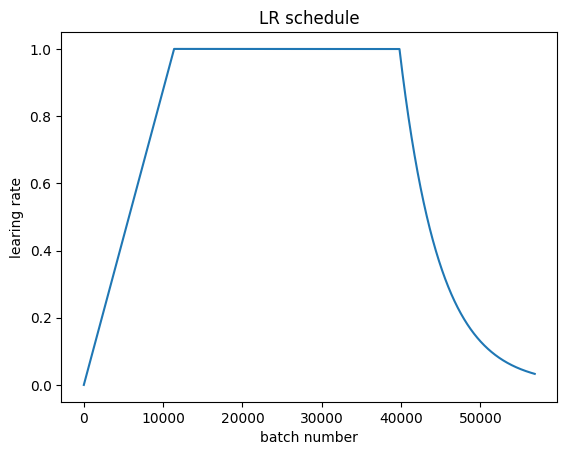

In [10]:
import matplotlib.pyplot as plt

n_steps = len(train_dataloader) * N_EPOCH
plt.plot(np.arange(n_steps), [schedule(step) for step in np.arange(n_steps)])
plt.title('LR schedule')
plt.ylabel('learing rate')
plt.xlabel('batch number');

In [11]:
from IPython.display import clear_output

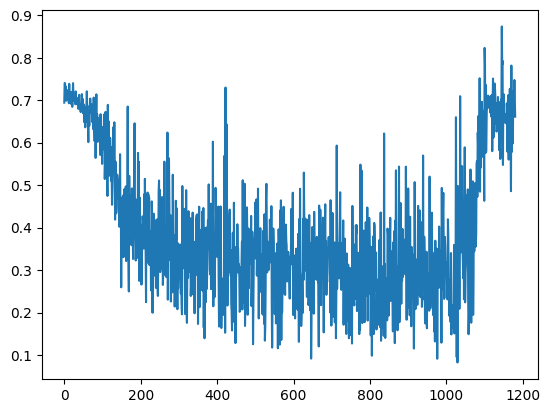

Process Process-7:
Process Process-6:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line

In [13]:
%%time

DEVICE = 'cuda:2'

new_model = transformers.AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large').to(DEVICE)
new_model.train()
optimizer = torch.optim.Adam(new_model.parameters(), 3e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
losses = []

for _ in range(N_EPOCH):
    for i, batch in enumerate(train_dataloader):
        predicted = new_model(
            input_ids=batch['input_ids'].to(DEVICE),
            attention_mask=batch['attention_mask'].to(DEVICE),
            token_type_ids=batch['token_type_ids'].to(DEVICE)
        )
        loss = F.cross_entropy(predicted.logits, batch['labels'].to(DEVICE))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if i % 20 == 0:
            clear_output()
            plt.plot(np.arange(len(losses)), losses)
            plt.show()

Почему так?

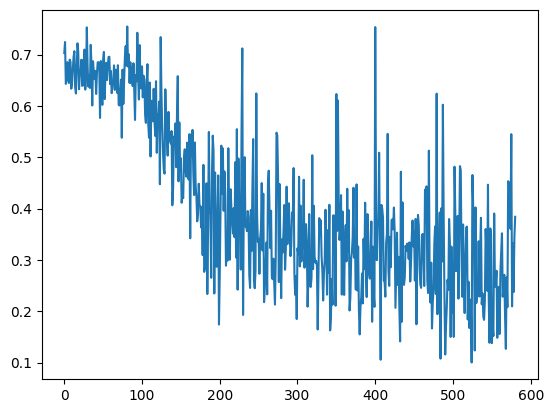

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fce2fa41440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._sele

KeyboardInterrupt: 

In [16]:
%%time

DEVICE = 'cuda:1'

new_model = transformers.AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large').to(DEVICE)
new_model.train()
optimizer = torch.optim.Adam(new_model.parameters(), 3e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
losses = []

for _ in range(N_EPOCH):
    for i, batch in enumerate(train_dataloader):
        predicted = new_model(
            input_ids=batch['input_ids'].to(DEVICE),
            attention_mask=batch['attention_mask'].to(DEVICE),
            token_type_ids=batch['token_type_ids'].to(DEVICE)
        )
        loss = F.cross_entropy(predicted.logits, batch['labels'].to(DEVICE))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if i % 20 == 0:
            clear_output()
            plt.plot(np.arange(len(losses)), losses)
            plt.show()

In [17]:
val_dataloader = torch.utils.data.DataLoader(
    qqp_preprocessed['validation'],
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
    collate_fn=transformers.default_data_collator,
)

In [19]:
BATCH_SIZE = 32
DEVICE = 'cuda'

labels, answers = np.zeros(len(qqp_preprocessed['validation'])), np.zeros(len(qqp_preprocessed['validation']))
new_model = new_model.to(DEVICE)
new_model.eval()

with torch.no_grad():
    for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = batch['labels']
        predicted = new_model(
          input_ids=batch['input_ids'].to(DEVICE),
          attention_mask=batch['attention_mask'].to(DEVICE),
          token_type_ids=batch['token_type_ids'].to(DEVICE)
        )
        answers[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.softmax(
            predicted.logits, dim=1
        ).argmax(dim=1).cpu().detach().numpy()

accuracy = (labels == answers).mean()
accuracy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.8674251793222855

In [20]:
# option A
# model https://huggingface.co/microsoft/deberta-v3-large
DEVICE = 'cuda:2'
class MyBertModelForQQP(nn.Module):
    model_name = 'microsoft/deberta-v3-large'
    
    def __init__(self):
        super().__init__()
        self.bert = transformers.AutoModel.from_pretrained(self.model_name)
        self.head = nn.Linear(1024, 2)
        
    def forward(self, x):
        out = self.bert(**x)['last_hidden_state'].mean(dim=1)
#         print(dir(out))
        return self.head(out)

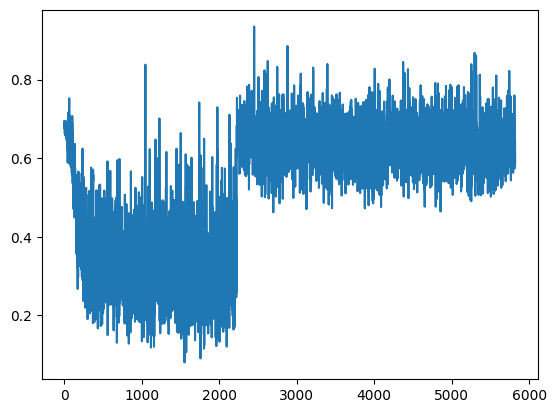

Process Process-22:
Process Process-24:
Process Process-23:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/local/lib/python3.11/multiprocessing/util.py", l

KeyboardInterrupt: 

In [21]:
%%time

my_model = MyBertModelForQQP().to(DEVICE)
my_model.train()
optimizer = torch.optim.Adam(my_model.parameters(), 3e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
losses = []

for _ in range(N_EPOCH):
    for i, batch in enumerate(train_dataloader):
        predicted = my_model({
            'input_ids': batch['input_ids'].to(DEVICE),
            'attention_mask': batch['attention_mask'].to(DEVICE),
            'token_type_ids': batch['token_type_ids'].to(DEVICE),
        })
        loss = F.cross_entropy(predicted, batch['labels'].to(DEVICE))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if i % 20 == 0:
            clear_output()
            plt.plot(np.arange(len(losses)), losses)
            plt.show()

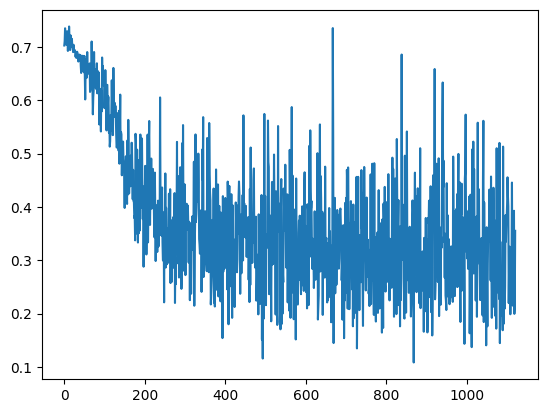

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fce2fa41440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._sele

KeyboardInterrupt: 

In [22]:
%%time

my_model = MyBertModelForQQP().to(DEVICE)
my_model.train()
optimizer = torch.optim.Adam(my_model.parameters(), 3e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
losses = []

for _ in range(N_EPOCH):
    for i, batch in enumerate(train_dataloader):
        predicted = my_model({
            'input_ids': batch['input_ids'].to(DEVICE),
            'attention_mask': batch['attention_mask'].to(DEVICE),
            'token_type_ids': batch['token_type_ids'].to(DEVICE),
        })
        loss = F.cross_entropy(predicted, batch['labels'].to(DEVICE))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if i % 20 == 0:
            clear_output()
            plt.plot(np.arange(len(losses)), losses)
            plt.show()

In [23]:
BATCH_SIZE = 32
DEVICE = 'cuda'

labels, answers = np.zeros(len(qqp_preprocessed['validation'])), np.zeros(len(qqp_preprocessed['validation']))
my_model = my_model.to(DEVICE)
my_model.eval()

with torch.no_grad():
    for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = batch['labels']
        predicted = my_model({
          'input_ids': batch['input_ids'].to(DEVICE),
          'attention_mask': batch['attention_mask'].to(DEVICE),
          'token_type_ids': batch['token_type_ids'].to(DEVICE),
        })
        answers[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.softmax(
            predicted, dim=1
        ).argmax(dim=1).cpu().detach().numpy()

accuracy = (labels == answers).mean()
accuracy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.8754637645312886

### Task 3: try the full pipeline (1 point)

Finally, it is time to use your model to find duplicate questions.
Please implement a function that takes a question and finds top-5 potential duplicates in the training set. For now, it is fine if your function is slow, as long as it yields correct results.

Showcase how your function works with at least 5 examples.

In [69]:
from typing import List

def prepare_base(qqp_train) -> List[str]:
    base = []
    for example in qqp_train:
        base += [example['text1'], example['text2']]
    return base

In [70]:
ALL_TRAIN_EXAMPLES = prepare_base(qqp_preprocessed['train'])
len(ALL_TRAIN_EXAMPLES)

727692

In [110]:
def get_duplicates(text: str, base: List[str], model, tokenizer, topK: int = 5, batch_size: int = 64):
    print('-'*100)
    print(f'{"-"*47}INPUT{"-"*48}')
    print(text)
    print('-'*100)
    print(f'{"-"*44}SUGGESTIONS{"-"*45}')
    model.eval()
    scores = np.zeros(len(base))
    with torch.no_grad():
        for i in tqdm(range(0, len(base), batch_size), total=(
            len(base) // batch_size + int(len(base) % batch_size != 0)
        )):
            batch = base[i : i+batch_size]
            inp = tokenizer(
                text=[text]*len(batch),
                text_pair=batch,
                padding=True,
                truncation=True,
                max_length=MAX_LENGTH,
            )
            predict = model({
                key: torch.tensor(value).to(DEVICE) for key, value in inp.items()
            })
            scores[i : i+batch_size] = torch.softmax(predict, dim=1)[:, 1].cpu().detach().numpy()
            
    for arg in reversed(np.argsort(scores)[-topK:]):
        print(f'SCORE: {scores[arg]:.4f} TEXT: {base[arg]}')

In [115]:
%%time

get_duplicates(
    text=qqp_preprocessed['train'][5]['text1'],
    base=ALL_TRAIN_EXAMPLES,
    model=my_model,
    tokenizer=tokenizer,
    batch_size=32,
)

----------------------------------------------------------------------------------------------------
-----------------------------------------------INPUT------------------------------------------------
How not to feel guilty since I am Muslim and I'm conscious we won't have sex together?
----------------------------------------------------------------------------------------------------
--------------------------------------------SUGGESTIONS---------------------------------------------


100%|██████████| 22741/22741 [42:55<00:00,  8.83it/s] 


SCORE: 1.0000 TEXT: How not to feel guilty since I am Muslim and I'm conscious we won't have sex together?
SCORE: 0.9992 TEXT: How can I create an app similar to Uber/Ola on a small scale? How can I create an app similar to Uber/Ola on a small scale?
SCORE: 0.9981 TEXT: Why did Modi scrap Rs 500 & Rs 1000 notes? And what's the reason for the sudden introduction of the 2000 rupee note?
SCORE: 0.9981 TEXT: Why did Modi scrap Rs 500 & Rs 1000 notes? And what's the reason for the sudden introduction of the 2000 rupee note?
SCORE: 0.9981 TEXT: Why did Modi scrap Rs 500 & Rs 1000 notes? And what's the reason for the sudden introduction of the 2000 rupee note?
CPU times: user 48min 59s, sys: 26min 58s, total: 1h 15min 58s
Wall time: 42min 55s


In [116]:
%%time

get_duplicates(
    text='What will be if I use Convolutional Neural Networks for Sequence Classification?',
    base=list(set(ALL_TRAIN_EXAMPLES)),
    model=my_model,
    tokenizer=tokenizer,
    batch_size=32,
)

----------------------------------------------------------------------------------------------------
-----------------------------------------------INPUT------------------------------------------------
What will be if I use Convolutional Neural Networks for Sequence Classification?
----------------------------------------------------------------------------------------------------
--------------------------------------------SUGGESTIONS---------------------------------------------


100%|██████████| 15434/15434 [27:36<00:00,  9.31it/s]


SCORE: 1.0000 TEXT: How difficult is it to get a job after studying as an international student? How difficult is it to get a job after studying as an international student?
SCORE: 1.0000 TEXT: Why do my dogs fight with each other? I have two lovely pedigreed dogs but sometimes they fight with each other. Why do they fight with each other?
SCORE: 0.9998 TEXT: How does one learn to become a good DJ? What are the best ways to learn to DJ?
SCORE: 0.9997 TEXT: Why did Modi scrap Rs 500 & Rs 1000 notes? And what's the reason for the sudden introduction of the 2000 rupee note?
SCORE: 0.9997 TEXT: How can I create an app similar to Uber/Ola on a small scale? How can I create an app similar to Uber/Ola on a small scale?
CPU times: user 33min 35s, sys: 17min 3s, total: 50min 39s
Wall time: 27min 37s


Сомнительно, но окэй 🤔

In [118]:
%%time

get_duplicates(
    text='What to give my dad for his birthday if he loves fishing?',
    base=list(set(ALL_TRAIN_EXAMPLES)),
    model=my_model,
    tokenizer=tokenizer,
    batch_size=32,
)

----------------------------------------------------------------------------------------------------
-----------------------------------------------INPUT------------------------------------------------
What to give my dad for his birthday if he loves fishing?
----------------------------------------------------------------------------------------------------
--------------------------------------------SUGGESTIONS---------------------------------------------


100%|██████████| 15434/15434 [26:47<00:00,  9.60it/s]


SCORE: 1.0000 TEXT: How difficult is it to get a job after studying as an international student? How difficult is it to get a job after studying as an international student?
SCORE: 0.9999 TEXT: Why do my dogs fight with each other? I have two lovely pedigreed dogs but sometimes they fight with each other. Why do they fight with each other?
SCORE: 0.9998 TEXT: How can I create an app similar to Uber/Ola on a small scale? How can I create an app similar to Uber/Ola on a small scale?
SCORE: 0.9993 TEXT: Why did Modi scrap Rs 500 & Rs 1000 notes? And what's the reason for the sudden introduction of the 2000 rupee note?
SCORE: 0.9976 TEXT: If you were an animal what animal do you think you would be and why? What animal do you wish you could be and why?
CPU times: user 32min 41s, sys: 16min 26s, total: 49min 8s
Wall time: 26min 47s


__Bonus:__ for bonus points, try to find a way to run the function faster than just passing over all questions in a loop. For isntance, you can form a short-list of potential candidates using a cheaper method, and then run your tranformer on that short list. If you opted for this solution, please keep both the original implementation and the optimized one - and explain briefly what is the difference there.